## Cодержание:
* [First Bullet Header](#first-bullet)
* [Second Bullet Header](#second-bullet)

# Команда: Бета Банк


**Цель:** Создать CLTV модель, которая будет выдавать вероятности перехода в каждый из 17 продуктовых кластеров в течение 12 месяцев.

Альфа-Банком предоставлены следующие **данные**:

-   Тренировочный датасет `train_data.pqt` содержит данные о 200 000 клиентах банка и их целевых переменных за три последовательных месяца (month_1, month_2, month_3)
-   Тестовый датасет `test_data.pqt` записи о 100 000 клиентах за 3 последовательных месяца (month_4, month_5, month_6)
   
-   Продуктовый кластер, в котором клиент будет находится через год - `end_cluster`. Необходимо получить вероятности перехода клиента в продуктовые кластеры для последнего месяца (month_6).

  
-    Метрикой качества выступает **ROC-AUC**.

Данные о клиентах и масскированы.

## Подключение модулей

In [4]:
!pip install catboost

^C
ERROR: Operation cancelled by user


In [2]:
# работа с ОС
import os
import warnings
import time
# работа с данными
import json
import numpy as np
import pandas as pd
from typing import Optional, Dict, Tuple
# визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from matplotlib.ticker import MaxNLocator
# работа с ML
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# модели машинного обучения
# import optuna
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
# обработка ошибок
from pyarrow import ArrowInvalid
# настройка среды выполнения
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

## Задание

1. Качественно оформите код модели
2. Доработка решения на платформе будет открыта до 18 апреля 12:00
3. Обязательно наличие .README;
4. Код должен быть читабелен и понятен;
5. Решение должно быть воспроизводимо: эксперты должны иметь возможность протестировать ваше решение на финале.

## Загрузка и изучение данных

In [6]:
def read_df(filepath: str) -> Optional[pd.DataFrame]:
    """
    Функция для чтения датасета по указанному пути

    args:
    filepath (str) - путь к файлу .pqt / .parquet

    return:
    датасет в формате pd.DataFrame, если найден файл по указанному пути
    """
    if os.path.exists(filepath):
        try:
            result: pd.DataFrame = pd.read_parquet(filepath, engine='auto')
            print(f"Файл {filepath} успешно открыт")
            return result
        except ArrowInvalid:
            print("Неверный тип файла. Поддерживаемый - .pqt или .parquet")
            return
    print(f"Файл не найден по пути {filepath}")
    return

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
# Путь до файла train_df
path_train_df = "/kaggle/input/alfa-hackaton/train_data.pqt"
# Путь до файла test_df
path_test_df = "/kaggle/input/alfa-hackaton/test_data.pqt"

# чтение файлов
train_df = read_df(path_train_df)
test_df = read_df(path_test_df)

# объединение файлов
df = pd.concat([train_df, test_df], ignore_index=True)

display(train_df.head(2))
display(test_df.head(2))

Файл /kaggle/input/alfa-hackaton/train_data.pqt успешно открыт
Файл /kaggle/input/alfa-hackaton/test_data.pqt успешно открыт


,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9512,0.5687,0.8976,0.5536,0.7744,0.9365,0.2960,0.9679,"{α, γ}",{other}
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9488,0.4997,0.7850,0.5519,0.6966,0.9902,0.2989,0.9460,"{α, γ}",{other}


,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.0962,0.3355,-0.1260,-0.0956,channel_code_12,city_14,city_type_0,None,...,0.0110,0.9461,0.4078,-0.1540,0.5489,0.5410,0.0317,0.2573,0.5614,{α}
1,200000,month_5,-0.0243,-0.0598,-0.1243,-0.0234,channel_code_12,city_14,city_type_0,None,...,0.0068,0.9453,0.3963,-0.1505,0.5495,0.5521,0.2378,0.2642,0.7152,{α}


### Базовый анализ данных

In [18]:
print(f"Количество записей в тренировочных данных: {len(train_df)}")
print(f"Количество записей в тестовых данных: {len(test_df)}")

Количество записей в тренировочных данных: 600000
Количество записей в тестовых данных: 290120


В тестовой выборке у клиентов нет информации по 4 или 5 месяцу.

In [19]:
df.dtypes.value_counts()

float64    81
object     11
int64       1
Name: count, dtype: int64

Признаки по большей части представляют собой числа с плавающей точкой, также присутствует 11 категориальных признаков, их необходимо закодировать.

In [22]:
df[df.duplicated(subset=df.columns.difference(['id']), keep=False)].shape

(44530, 93)

Дубликаты записей есть.

In [23]:
df['start_cluster'].value_counts()

start_cluster
{α}          491192
{}           107072
{α, η}        57458
{α, γ}        43129
{other}       42545
{α, β}        13498
{α, δ}        11350
{α, ε}         7464
{α, θ}         6348
{α, ψ}         3876
{α, μ}         1883
{α, ε, η}      1620
{α, ε, θ}      1083
{α, λ}          997
{α, ε, ψ}       462
{λ}             114
{α, π}           29
Name: count, dtype: int64

Распределение основного признака (начального кластера, из которого будет осуществляться переход в конечный кластер, являющийся целевой переменной) сильно дизбалансное.

## Предобработка данных

### Восстановление численных признаков

Признаки, описывающие статистические показатели определённой операции можно обобщить с помощью признаков "общей суммы" операций и "количества" операций. Это введёт дополнительный признак для улучшения качества модели.

In [24]:
numeric_cols = df.drop(columns=['id']).select_dtypes(include=['number']).columns.tolist()
for col in numeric_cols:
    # получением минимального возможного значения признака
    mean_val = df[col].mean()
    # заполнение пропущенных значений минимальным значением признака
    df[col].fillna(mean_val, inplace=True)

Для начала были восстановленны пропущенные записи у всех численных признаков средними значениями признака.

In [25]:
df['avg_a_oper_1m'] = df['sum_a_oper_1m'] / df['cnt_a_oper_1m']
df['avg_b_oper_1m'] = df['sum_b_oper_1m'] / df['cnt_b_oper_1m']
df['avg_c_oper_1m'] = df['sum_c_oper_1m'] / df['cnt_c_oper_1m']

df['avg_deb_d_oper_1m'] = df['sum_deb_d_oper_1m'] / df['cnt_deb_d_oper_1m']
df['avg_cred_d_oper_1m'] = df['sum_cred_d_oper_1m'] / df['cnt_cred_d_oper_1m']

df['avg_deb_e_oper_1m'] = df['sum_deb_e_oper_1m'] / df['cnt_deb_e_oper_1m']
df['avg_cred_e_oper_1m'] = df['sum_cred_e_oper_1m'] / df['cnt_cred_e_oper_1m']


df['avg_deb_f_oper_1m'] = df['sum_deb_f_oper_1m'] / df['cnt_deb_f_oper_1m']
df['avg_cred_f_oper_1m'] = df['sum_cred_f_oper_1m'] / df['cnt_cred_f_oper_1m']

df['avg_deb_g_oper_1m'] = df['sum_deb_g_oper_1m'] / df['cnt_deb_g_oper_1m']
df['avg_cred_g_oper_1m'] = df['sum_cred_g_oper_1m'] / df['cnt_cred_g_oper_1m']

df['avg_deb_h_oper_1m'] = df['sum_deb_h_oper_1m'] / df['cnt_deb_h_oper_1m']
df['avg_cred_h_oper_1m'] = df['sum_cred_h_oper_1m'] / df['cnt_cred_h_oper_1m']


df['avg_a_oper_3m'] = df['sum_a_oper_3m'] / df['cnt_a_oper_3m']
df['avg_b_oper_3m'] = df['sum_b_oper_3m'] / df['cnt_b_oper_3m']
df['avg_c_oper_3m'] = df['sum_c_oper_3m'] / df['cnt_c_oper_3m']

df['avg_deb_d_oper_3m'] = df['sum_deb_d_oper_3m'] / df['cnt_deb_d_oper_3m']
df['avg_cred_d_oper_3m'] = df['sum_cred_d_oper_3m'] / df['cnt_cred_d_oper_3m']

df['avg_deb_e_oper_3m'] = df['sum_deb_e_oper_3m'] / df['cnt_deb_e_oper_3m']
df['avg_cred_e_oper_3m'] = df['sum_cred_e_oper_3m'] / df['cnt_cred_e_oper_3m']

df['avg_deb_f_oper_3m'] = df['sum_deb_f_oper_3m'] / df['cnt_deb_f_oper_3m']
df['avg_cred_f_oper_3m'] = df['sum_cred_f_oper_3m'] / df['cnt_cred_f_oper_3m']

df['avg_deb_g_oper_3m'] = df['sum_deb_g_oper_3m'] / df['cnt_deb_g_oper_3m']
df['avg_cred_g_oper_3m'] = df['sum_cred_g_oper_3m'] / df['cnt_cred_g_oper_3m']

df['avg_deb_h_oper_3m'] = df['sum_deb_h_oper_3m'] / df['cnt_deb_h_oper_3m']
df['avg_cred_h_oper_3m'] = df['sum_cred_h_oper_3m'] / df['cnt_cred_h_oper_3m']

Введение дополнительного признака "среднего" по каждой операции каждого клиента за каждый месяц.

Стоит предположить малую вероятность того, что кластер клиента за ближайшие месяцы поменяется:

Отсюда следует, что пропущенные категориальные признаки можно восстановить последним значеним признака для клиента.

In [26]:
def restore_cal(x: pd.Series) -> pd.Series:
    """
    Функция восстановления категориального признака последним значением для
    конкретного клиента

    args:
    x (pd.Series) - значения рассматриваемого признака в группе

    return:
    Возвращается группа с восстановленным пропущенным значением
    """
    # если есть пропущеные значения
    if x.isna().any() and not x.isna().all():
        # заполняем пропущенное значение последним в группе
        return x.fillna(x.dropna().iloc[-1])
    # если все пропуски, заполняем 'missing'
    elif x.isna().all():
        return x.fillna('missing')
    # если нет пропусков, возвращаем исходную группу
    return x

In [27]:
cat_columns_to_restore = ['channel_code', 'city', 'city_type', 'ogrn_month', 'ogrn_year', 'okved', 'segment']
for column in cat_columns_to_restore:
    start_time = time.time()
    df[column] = df.groupby('id')[column].apply(restore_cal).reset_index()[column]
    end_time = time.time()
    print(f"Колонка - {column} - восстановлена {end_time - start_time}")

Колонка - channel_code - восстановлена 69.99003601074219
Колонка - city - восстановлена 72.08723568916321
Колонка - city_type - восстановлена 71.24171614646912
Колонка - ogrn_month - восстановлена 67.95592451095581
Колонка - ogrn_year - восстановлена 69.0119161605835
Колонка - okved - восстановлена 66.9500424861908
Колонка - segment - восстановлена 66.49515962600708


In [43]:
df.to_parquet("df_after_cat_restore_fill_min.pqt")

In [44]:
df = pd.read_parquet("df_after_cat_restore_fill_min.pqt")
df['date'] = df['date'].replace({'month_4': 'month_1', 'month_5': 'month_2', 'month_6': 'month_3'})


KeyError: 'date'

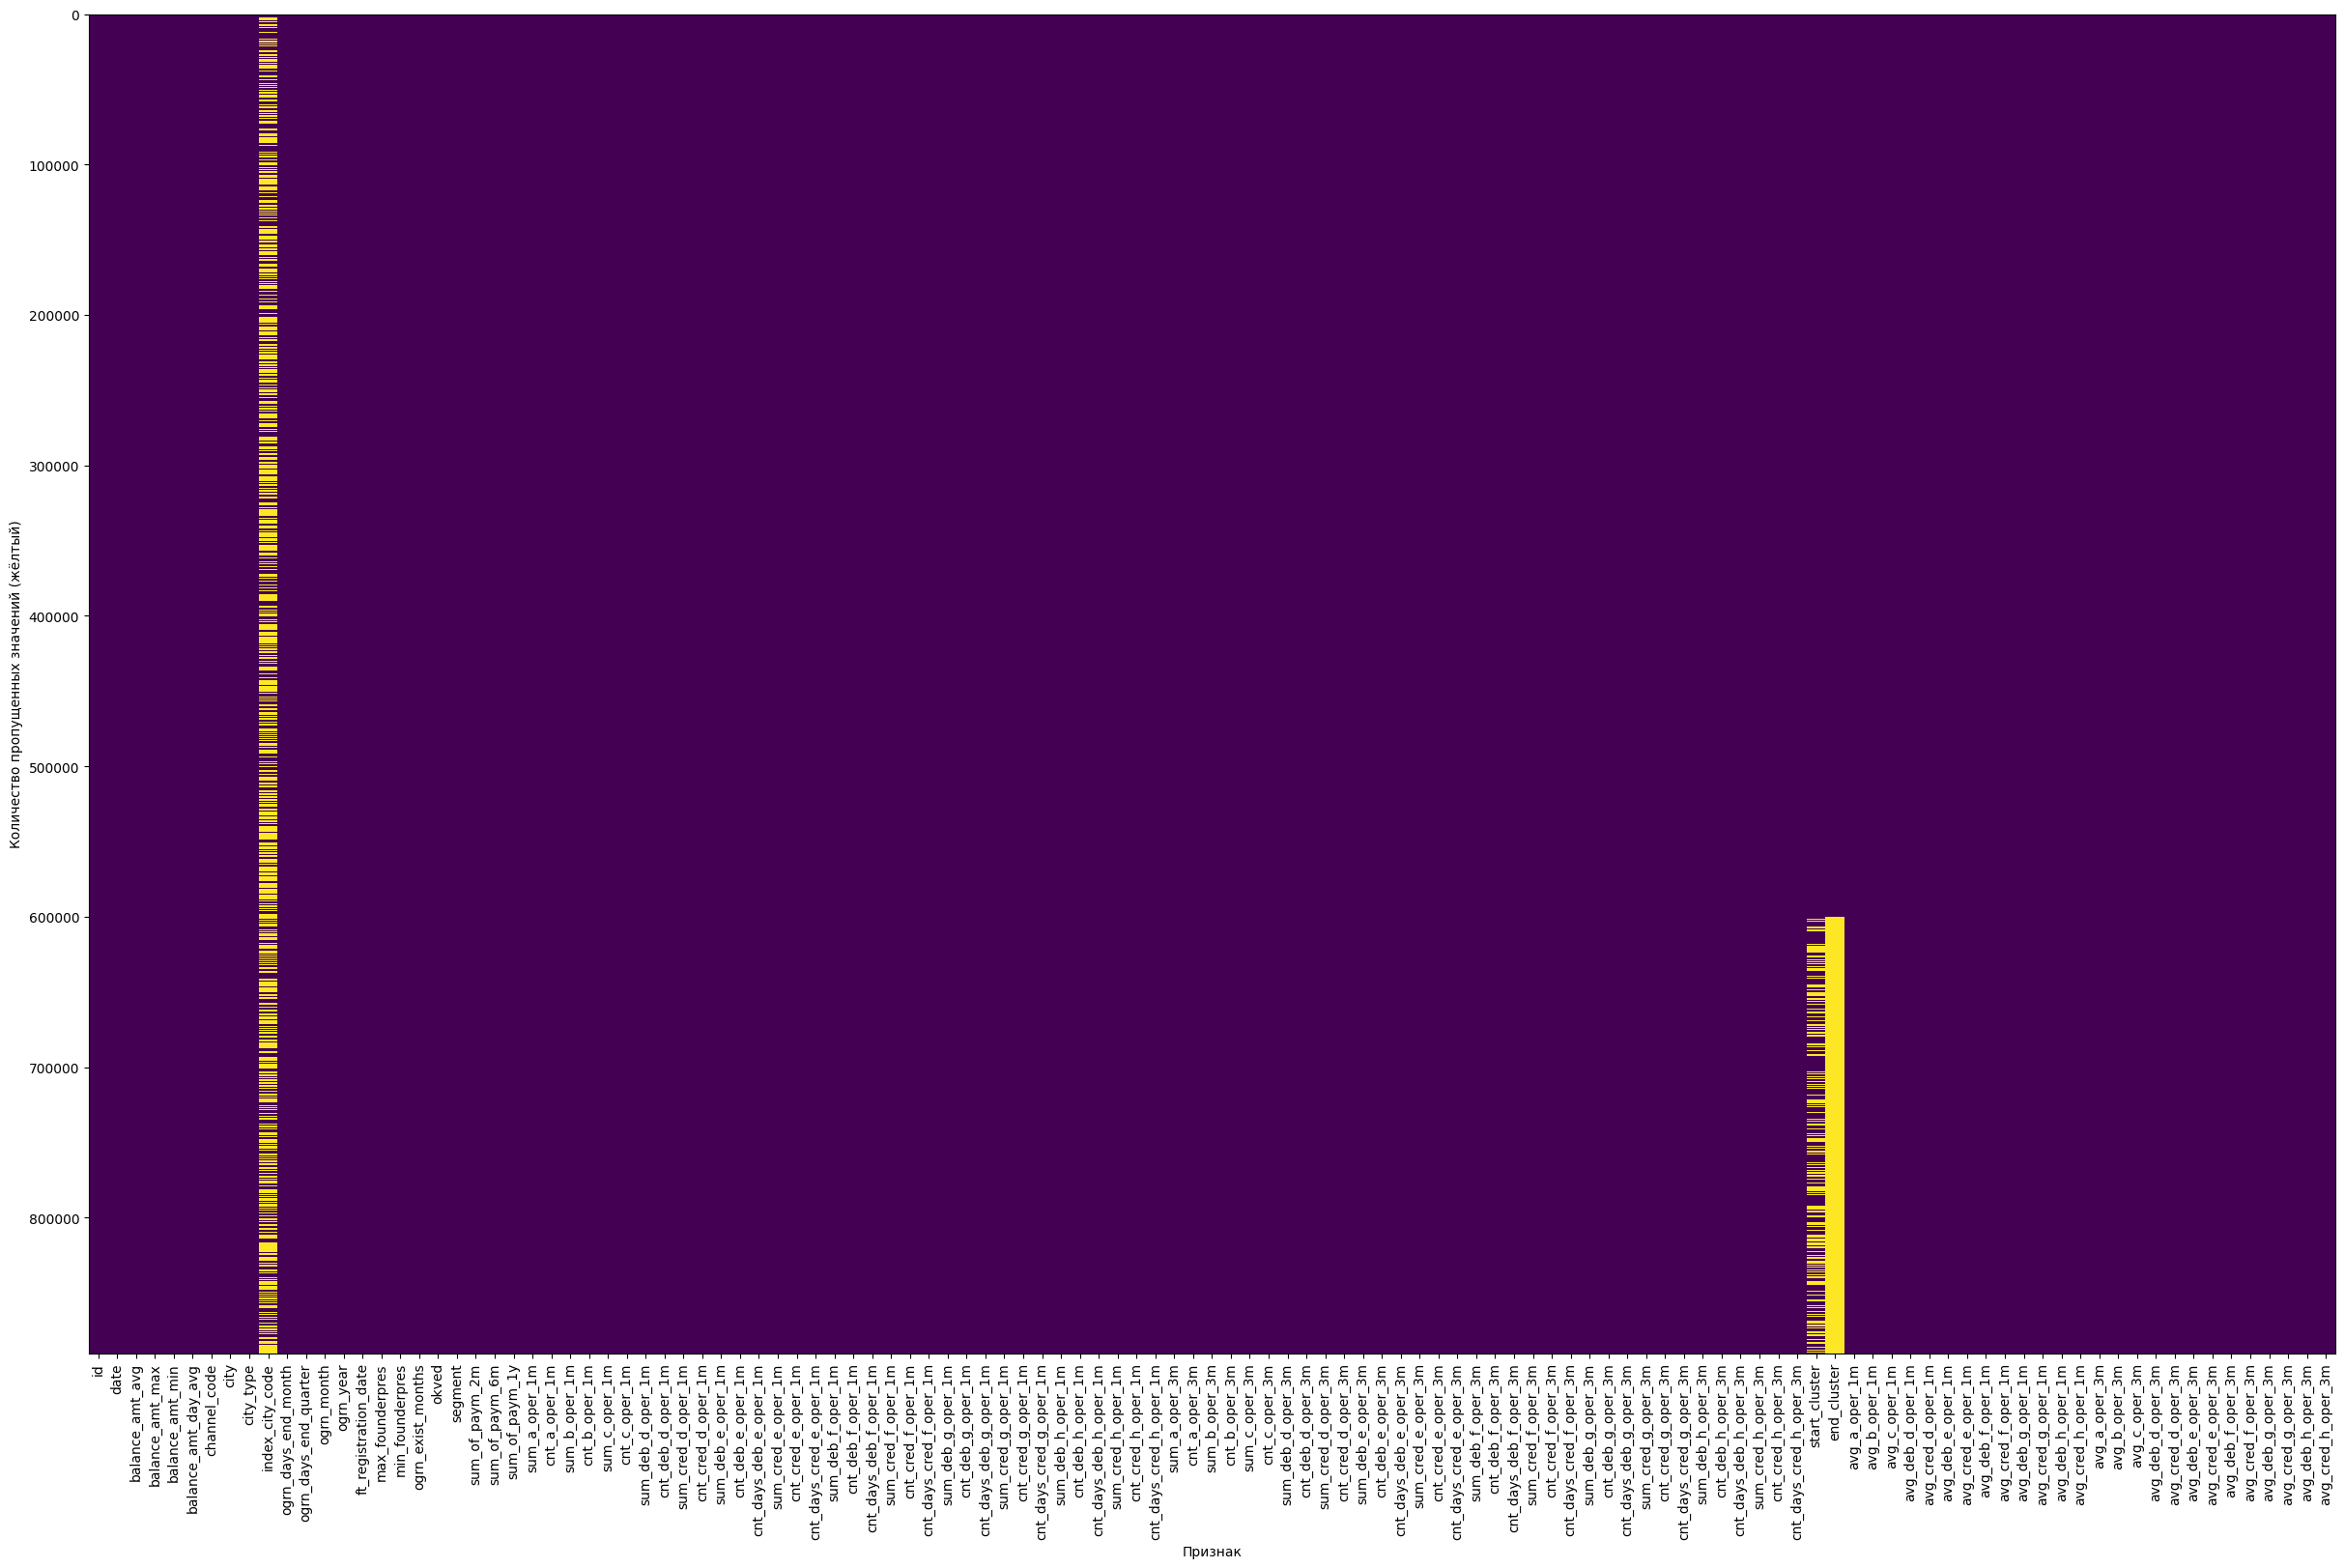

In [9]:
def plt_null_df(df: pd.DataFrame) -> None:
    """
    Функция построение графика пропущенных значений в признаках

    args:
    df (pd.DataFrame) - датафрейм с рассматриваемыми признаками

    return:
    Функция строит график без возврата результата
    """
    plt.figure(figsize=(30, 18))
    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")
    # указание признаков в качестве отметок на оси абсцисс
    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
    # имена осей
    plt.xlabel("Признак")
    plt.ylabel("Количество пропущенных значений (жёлтый)")
    # визуализация графика
    plt.show()
    
plt_null_df(df.isna())

### Создание таблицы с 3 месяцами

In [ ]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "ogrn_month", "ogrn_year",
]
cat_cols_month_1 = [f'{col}_month_1' for col in cat_cols]
cat_cols_month_2 = [f'{col}_month_2' for col in cat_cols]
# сводная таблица по клиентам и месяцам
df = df.pivot_table(index='id', columns='date', aggfunc='first')
df.columns = [f'{col[0]}_{col[1]}' for col in df.columns]
df.reset_index(inplace=True)
df = df.drop(
    columns=['end_cluster_month_1', 'end_cluster_month_2'] + cat_cols_month_1 + cat_cols_month_2,
    axis=0)
categorical_columns = df.select_dtypes(include=['object']).columns

# заполняем пропущенные элементы новой категорией, так как у клиентов может не быть 4, 5 месяца
df[categorical_columns] = df[categorical_columns].fillna("missing")

In [12]:
# получение только численных признаков
numeric_cols = df.drop(columns=['id']).select_dtypes(include=['number']).columns.tolist()
for col in numeric_cols:
    # получением минимального возможного значения признака
    mean_val = df[col].mean()
    # заполнение пропущенных значений минимальным значением признака
    df[col].fillna(mean_val, inplace=True)

### Восстановление start_claster с помощью Catboost 

In [13]:
# выделяем тренировочные данные (без пропущенных значений целевой переменной)
train_data = df[df['start_cluster_month_3'] != 'missing'].drop(
    ['id', 'end_cluster_month_3'], axis=1)
# выделяем тестовые данные (пропущенные значения целевой переменной)
predict_data = df[df['start_cluster_month_3'] == 'missing'].drop(
    ['id', 'end_cluster_month_3'], axis=1)

# получаем признаки для обучения и целевую переменную
X = train_data.drop('start_cluster_month_3', axis=1)
y = train_data['start_cluster_month_3']

# разбиваем на подвыборки обучения и тестирования 80/20
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

#### Обучение CATBOOST

In [14]:
# архитектура модели
catboost_model_start_cluster = CatBoostClassifier(
    iterations=1024,            # кол-во итераций обучения
    depth=6,                    # рекомендованная глубина модели
    learning_rate=0.075,        # скорость обучения
    random_seed=47,             # сид для воспроизводимости результата
    loss_function='MultiClass', # тип модели или функция ошибки
    task_type="GPU",            # обучение на видеокарте
    devices='0',
    early_stopping_rounds=20    # регуляризация ранней остановкой в случае
                                # отстутсвия изменения ф. ошибки 20 итераций
    )

In [15]:
def train_catboost(model: CatBoostClassifier,
                   x_train: pd.DataFrame, y_train: pd.Series,
                   x_val: pd.DataFrame, y_val: pd.Series,
                   cat_names: pd.core.indexes.base.Index,
                   model_name: str,
                   verbose_step: int = 100) -> pd.DataFrame:
    """
    Функция обучения, тестирования и сохранения модели catboost

    args:
    model (CatBoostClassifier) - модель catboost
    x_train (pd.DataFrame) - датафрейм для обучения
    y_train (pd.Series) - целевая переменная в обучении
    x_val (pd.DataFrame) - датафрейм для тестирования точности модели
    y_train (pd.Series) - целевая переменная в тестировании
    cat_names (pd.core.indexes.base.Index) - список категориальных признаков
    из тренировочного и тестового датафреймов для автоматической предобработки
    самой моделью
    model_name (str) - имя модели для сохранения
    verbose_step (int) - шаг вывода статуса модели

    return:
    Возвращается важность признаков модели
    """
    model.fit(
        x_train, y_train,                   # обучающая выборка
        cat_features=np.array(cat_names),   # категориальные признаки
        eval_set=(x_val, y_val),            # тестовая выборка
        verbose=verbose_step                         # шаг вывода статуса модели
    )
    # сохранение модели
    model.save_model(f'{model_name}.json')
    # получение важности признаков
    feature_importance = model.get_feature_importance(prettified=True)
    return feature_importance

In [16]:
# получаем список категориальных признаков
cat_names = X.select_dtypes(include=['object']).columns
# обучение модели с получением важности признаков
feature_importance = train_catboost(
    catboost_model_start_cluster, X_train, y_train, X_val, y_val, cat_names,
    'catboost_model_start_cluster')

0:	learn: 1.9166969	test: 1.8946137	best: 1.8946137 (0)	total: 317ms	remaining: 5m 23s
100:	learn: 0.2481591	test: 0.2259392	best: 0.2259392 (100)	total: 6.31s	remaining: 57.7s
200:	learn: 0.2268876	test: 0.2142327	best: 0.2142327 (200)	total: 12s	remaining: 49s
300:	learn: 0.2191546	test: 0.2109279	best: 0.2109279 (300)	total: 17.3s	remaining: 41.6s
400:	learn: 0.2141711	test: 0.2090100	best: 0.2090100 (400)	total: 22.6s	remaining: 35.2s
500:	learn: 0.2099775	test: 0.2079333	best: 0.2079333 (500)	total: 27.9s	remaining: 29.2s
600:	learn: 0.2061583	test: 0.2069412	best: 0.2069397 (599)	total: 33.3s	remaining: 23.4s
700:	learn: 0.2023668	test: 0.2062508	best: 0.2062508 (700)	total: 38.8s	remaining: 17.9s
800:	learn: 0.1987928	test: 0.2055269	best: 0.2055259 (799)	total: 44.5s	remaining: 12.4s
900:	learn: 0.1957002	test: 0.2051259	best: 0.2051244 (899)	total: 50.1s	remaining: 6.84s
1000:	learn: 0.1925229	test: 0.2047179	best: 0.2047038 (997)	total: 55.9s	remaining: 1.28s
1023:	learn: 0.1

In [20]:
# предсказываем разные классы из тестовой подвыборки
y_pred = catboost_model_start_cluster.predict(X_val)
# статистика точности моделей по разным метрикам
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

     {other}       0.93      0.92      0.92      2432
          {}       0.88      0.86      0.87      3847
      {α, β}       0.92      0.93      0.92       710
      {α, γ}       0.94      0.93      0.93      2274
      {α, δ}       0.86      0.86      0.86       575
   {α, ε, η}       0.92      0.89      0.90       125
   {α, ε, θ}       0.88      0.81      0.84        53
   {α, ε, ψ}       0.85      0.83      0.84        35
      {α, ε}       0.90      0.85      0.87       369
      {α, η}       0.96      0.97      0.97      3651
      {α, θ}       0.91      0.88      0.89       322
      {α, λ}       0.76      0.85      0.80        67
      {α, μ}       0.85      0.84      0.84        93
      {α, π}       0.00      0.00      0.00         1
      {α, ψ}       0.94      0.92      0.93       331
         {α}       0.96      0.97      0.97     25112
         {λ}       1.00      0.33      0.50         3

    accuracy              

#### Восстанавление 6 месяца из тестовых данных

In [21]:
X_predict = predict_data.drop('start_cluster_month_3', axis=1)
predicted_clusters = catboost_model_start_cluster.predict(X_predict)

In [22]:
predicted_clusters_flat = np.ravel(predicted_clusters)
class_counts = pd.Series(predicted_clusters_flat).value_counts()
print(class_counts)

{α}          68408
{α, η}        8023
{}            6706
{other}       5744
{α, γ}        5095
{α, β}        1962
{α, δ}        1342
{α, ε}         791
{α, θ}         699
{α, ψ}         445
{α, μ}         269
{α, ε, η}      203
{α, λ}         148
{α, ε, θ}      113
{α, ε, ψ}       44
{λ}              8
Name: count, dtype: int64


In [23]:
predicted_index = 0

df_restore_start_cluster = df.copy()
for index, row in df_restore_start_cluster.iterrows():
    # Проверяем, содержится ли в столбце 'date' значение 'month6' и id >= 100000
    if row['id'] >= 200000:
        # Вставляем значение из серии в столбец 'start_cluster_month_3' текущей строки
        df_restore_start_cluster.at[index,
                                    'start_cluster_month_3'] = predicted_clusters[predicted_index][0]
        # Увеличиваем индекс текущей строки в серии
        predicted_index += 1

In [24]:
matching_rows = df_restore_start_cluster[df_restore_start_cluster['id'] >= 200000].loc[(df_restore_start_cluster['start_cluster_month_1'] == df_restore_start_cluster['start_cluster_month_2']) & (
    df_restore_start_cluster['start_cluster_month_2'] == df_restore_start_cluster['start_cluster_month_3'])]
matching_rows

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,...,sum_deb_h_oper_3m_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3
200000,200000,1.2619,-0.1648,6.2595,4.4611,4.6360,5.4649,-0.0693,-0.0693,-0.0693,...,-0.1528,0.6766,0.6884,0.6719,0.4168,0.4332,0.2240,0.3324,0.2843,0.2854
200001,200001,-0.4493,-0.4493,-0.4493,-0.9794,-0.9794,-0.9794,-0.0690,-0.0690,-0.0690,...,-0.1656,0.0035,0.0035,0.0035,0.0017,0.0017,0.0017,-0.0015,-0.0015,-0.0015
200002,200002,9.3303,43.0412,24.7229,16.9913,45.0169,49.5095,-0.0693,-0.0693,-0.0693,...,2.6149,0.3656,0.9705,1.2116,1.3040,3.8709,4.1425,0.5504,1.6208,1.9696
200003,200003,-0.4493,-0.4493,-0.4493,-0.9794,-0.9794,-0.9794,-0.0690,-0.0690,-0.0690,...,-0.1656,0.0035,0.0035,0.0035,0.0017,0.0017,0.0017,-0.0015,-0.0015,-0.0015
200006,200006,-0.4493,-0.4493,-0.4493,-0.9794,-0.9794,-0.9794,-0.0690,-0.0690,-0.0690,...,-0.1656,-0.2796,0.0035,0.0035,-0.2740,0.0017,0.0017,-0.2946,-0.0015,-0.0015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299994,299994,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1656,-0.2656,-0.2704,-0.2707,-0.2562,-0.2631,-0.2680,-0.2625,-0.2793,-0.2823
299995,299995,-0.4493,-0.4493,-0.4493,-0.9794,-0.9794,-0.9794,-0.0690,-0.0690,-0.0690,...,-0.1656,-0.2961,-0.2961,-0.2961,-0.2740,-0.2740,-0.2740,-0.2946,-0.2946,-0.2946
299996,299996,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,-0.1558,-0.2894,-0.2898,-0.2875,-0.2735,-0.2720,-0.2599,-0.2845,-0.2838,-0.2842
299997,299997,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,...,0.0879,-0.1378,-0.1119,-0.0847,-0.0707,-0.0416,-0.0087,-0.0990,-0.0826,-0.0688


## Обучение модели <a class="anchor" id="first-bullet"></a>

### Подготовка данных

In [34]:
# получаем обратно тренировочный и тестовый датасеты из общего
train_df = df_restore_start_cluster[df_restore_start_cluster['id']< 200000]
test_df = df_restore_start_cluster[df_restore_start_cluster['id'] >= 200000]
# получаем признаки для обучения и целевую переменную
X = train_df.drop(["id", "end_cluster_month_3"], axis=1)
y = train_df["end_cluster_month_3"]
# разбиваем на подвыборки обучения и тестирования 80/20
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [35]:
# архитектура модели
catboost_model_end_cluster = CatBoostClassifier(
    iterations=2025,            # кол-во итераций обучения
    depth=6,                    # рекомендованная глубина модели
    learning_rate=0.075,        # скорость обучения
    random_seed=47,             # сид для воспроизводимости результата
    loss_function='MultiClass', # тип модели или функция ошибки
    task_type="GPU",            # обучение на видеокарте
    devices='0',
    early_stopping_rounds=20    # регуляризация ранней остановкой в случае
                                # отстутсвия изменения функции ошибки 20
                                # итераций подряд
    )

In [36]:
cat_names = X_train.select_dtypes(include=['object']).columns

feature_importance = train_catboost(
    catboost_model_end_cluster, X_train, y_train, X_val, y_val, cat_names,
    'catboost_model_end_cluster')

0:	learn: 2.2483059	test: 2.2032293	best: 2.2032293 (0)	total: 124ms	remaining: 4m 11s
100:	learn: 0.8389839	test: 0.7675743	best: 0.7675743 (100)	total: 7.06s	remaining: 2m 14s
200:	learn: 0.8107582	test: 0.7524185	best: 0.7524185 (200)	total: 13.6s	remaining: 2m 3s
300:	learn: 0.7946259	test: 0.7469841	best: 0.7469841 (300)	total: 20.1s	remaining: 1m 54s
400:	learn: 0.7829652	test: 0.7443095	best: 0.7443005 (399)	total: 26.3s	remaining: 1m 46s
500:	learn: 0.7725202	test: 0.7428079	best: 0.7428046 (499)	total: 32.5s	remaining: 1m 38s
600:	learn: 0.7632695	test: 0.7414815	best: 0.7414815 (600)	total: 38.8s	remaining: 1m 32s
700:	learn: 0.7548373	test: 0.7403144	best: 0.7403144 (700)	total: 45.1s	remaining: 1m 25s
800:	learn: 0.7467390	test: 0.7396311	best: 0.7396025 (797)	total: 51.2s	remaining: 1m 18s
900:	learn: 0.7388356	test: 0.7392987	best: 0.7392987 (900)	total: 57.5s	remaining: 1m 11s
1000:	learn: 0.7310424	test: 0.7389379	best: 0.7389271 (996)	total: 1m 3s	remaining: 1m 5s
1100

In [37]:
feature_importance

,Feature Id,Importances
0,start_cluster_month_3,8.4888
1,okved_month_3,5.2330
2,city_month_3,3.6407
3,index_city_code_month_3,3.5524
4,segment_month_3,3.3233
...,...,...
329,cnt_days_cred_g_oper_1m_month_2,0.0000
330,city_type_month_3,0.0000
331,cnt_b_oper_1m_month_2,0.0000
332,cnt_days_cred_f_oper_3m_month_2,0.0000


## Тестирование модели

In [38]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [39]:
cluster_weights = pd.read_excel("/kaggle/input/alfa-hackaton/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [40]:
y_pred_proba = catboost_model_end_cluster.predict_proba(x_val)
weighted_roc_auc(y_val, y_pred_proba, catboost_model_end_cluster.classes_, weights_dict)

0.9198544864622821

Прогноз на тестовой выборке

In [41]:
sample_submission_df = pd.read_csv("/kaggle/input/alfa-hackaton/sample_submission.csv") # поменять на свой
last_m_test_df = test_df
last_m_test_df = last_m_test_df.drop(["id" , 'end_cluster_month_3'], axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = catboost_model_end_cluster.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=catboost_model_end_cluster.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("final.csv", index=False) # сохранение модели

In [42]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.0107,0.0162,0.0189,0.0206,0.0048,0.0003,0.0048,0.0003,0.0086,0.0041,0.0251,0.0009,0.0034,0.0000,0.0028,0.8786,0.0000
1,200001,0.0056,0.5076,0.0007,0.0015,0.0005,0.0002,0.0003,0.0000,0.0013,0.0071,0.0018,0.0002,0.0008,0.0000,0.0007,0.4714,0.0003
2,200002,0.5867,0.0052,0.0044,0.0793,0.0176,0.0048,0.0045,0.0220,0.0449,0.0155,0.0191,0.0121,0.0034,0.0000,0.0505,0.1300,0.0000
3,200003,0.0255,0.5914,0.0005,0.0012,0.0003,0.0006,0.0003,0.0000,0.0008,0.0126,0.0032,0.0000,0.0009,0.0000,0.0004,0.3623,0.0000
4,200004,0.0936,0.0913,0.0489,0.0218,0.0088,0.0035,0.0009,0.0001,0.0083,0.0519,0.0046,0.0008,0.0398,0.0000,0.0008,0.6248,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.0161,0.3189,0.0013,0.0054,0.0011,0.0000,0.0005,0.0000,0.0012,0.0010,0.0013,0.0003,0.0003,0.0000,0.0013,0.6512,0.0001
99996,299996,0.0191,0.0513,0.0070,0.0276,0.0056,0.0002,0.0004,0.0001,0.0072,0.0051,0.0088,0.0016,0.0017,0.0000,0.0017,0.8619,0.0007
99997,299997,0.0355,0.0312,0.0354,0.0549,0.0144,0.0001,0.0006,0.0005,0.0127,0.0035,0.0067,0.0010,0.0012,0.0000,0.0232,0.7790,0.0000
99998,299998,0.0871,0.0910,0.0219,0.0392,0.0103,0.0005,0.0030,0.0010,0.0223,0.0090,0.0104,0.0081,0.0016,0.0000,0.0039,0.6895,0.0012


---
## Выводы

Мы решали **задачу прогнозирования временного ряда спроса товаров** собственного производства на 14 дней вперёд.

Заказчиком предоставлены исторические данные о **продажах за 1 год**, а также в закодированном виде товарная иерархия и информация о магазинах.  
Прогнозировалось **число проданных товаров в штуках  `pr_sales_in_units`** для каждого **SKU/товара** (2050 шт. в обучающей выборке) в каждом из **10 магазинов**.

Основные **закономерности**, выявленные в результате анализа:
- ***Годовой тренд***  - спад средних продаж в зимний сезон октябрь-март.
- ***Недельная сезонность*** - пик продаж в субботу, спад в понедельник.
- В течение года несколько высоких ***пиков спроса, в основном в районе праздников***. Самые резкие подъёмы продаж в период Нового года и Пасхи. Подъем продаж начинается за несколько дней до.
- 40,6% записей относятся к продажам по промоакциям. Возможны одновременные продажи товара в одном магазине по промо и без.
- В данных представлены продукты с ***неполными временными рядами***: продавались только в дни около Пасхи, начали продаваться полгода назад.
- Во всех магазинах разный ассортимент товаров даже при условии одинаковых характеристик торговой точки.
- Все мета-признаки как характеристики магазинов и товаров показали влияние на средний спрос

На основе имеющихся данных **сгенерированы новые признаки:**  
- Календарные: день недели, число месяца, номер недели, флаг выходного дня (взят из доп. таблицы)
- Лаговые признаки 1-30 дней
- Скользящее среднее за 7 и 14 предыдущих дней
- Кластеризация по характеристикам магазинов и товаров
    
Чтобы временные ряды каждой комбинации Магазин-Товар были полными создан новый датасет, в который добавлены отсутствующие даты с нулевыми продажами.

 Обучение, валидация и выбор лучшего набора гиперпараметров проводится на **кросс-валидации Walk Forward**: подбор гиперпараметров на фолде проводится на valid-выборке, оценка лучшей модели на фолде на test-выборке.   
В итоге выбрана одна модель среди лучших на каждом фолде.

 Предсказание спроса обученной моделью делается последовательно на каждый следующий день с промежуточным перерасчётом лаговых признаков (учитывается предсказанное значение спроса в предыдущий день).

 Для оценки модели использовалась метрика качества  **WAPE**, посчитанная на уровне Магазин-Товар-Дата.  

Лучший результат по качеству и скорости показала модель градиентного бустинга **LightGBM**.  <br>
Полученный результат: WAPE = **0,47**, превышает baseline (предсказание последним известным значением) с метрикой 69%.


